In [1]:
from tensorflow.keras.models import load_model

# loaded_model = load_model('saved_models/NVspin_SimpleRNN_model.h5')
loaded_model = load_model('saved_models/NVspin_LSTM_model.h5')
# loaded_model = load_model('saved_models/NVspin_GRU_model.h5')

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv("data_results/NVspin_LSTM_data_results.csv")

# theta와 phi 값들을 numpy 배열로 변환
thetas = data['Theta'].to_numpy()
phis = data['Phi'].to_numpy()

sum = 0
iter = len(thetas)
num = 0
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

# theta와 phi 값들을 반복하며 fidelity 계산
for target_theta, target_phi in zip(thetas, phis):  
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp
     
     num += 1
     print(num, "/", iter)

print(sum/iter)

1/1 [==============================] - 1s 539ms/step
1 / 17254
1/1 [==============================] - 0s 29ms/step
2 / 17254
1/1 [==============================] - 0s 27ms/step
3 / 17254
1/1 [==============================] - 0s 29ms/step
4 / 17254
1/1 [==============================] - 0s 35ms/step
5 / 17254
1/1 [==============================] - 0s 38ms/step
6 / 17254
1/1 [==============================] - 0s 30ms/step
7 / 17254
1/1 [==============================] - 0s 25ms/step
8 / 17254
1/1 [==============================] - 0s 23ms/step
9 / 17254
1/1 [==============================] - 0s 27ms/step
10 / 17254
1/1 [==============================] - 0s 29ms/step
11 / 17254
1/1 [==============================] - 0s 26ms/step
12 / 17254
1/1 [==============================] - 0s 25ms/step
13 / 17254
1/1 [==============================] - 0s 26ms/step
14 / 17254
1/1 [==============================] - 0s 31ms/step
15 / 17254
1/1 [==============================] - 0s 26ms/step
16 / 17254


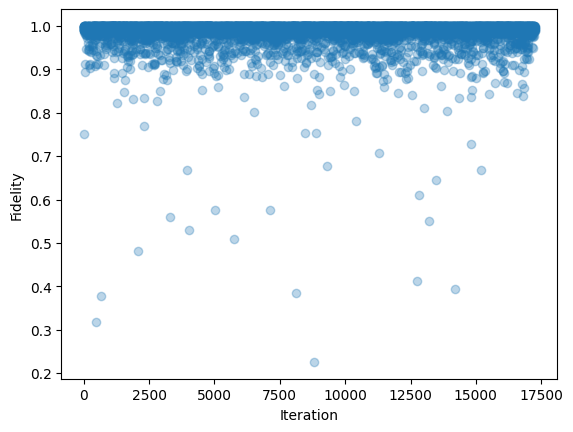

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

10 0.9883462763016525
19 0.9857896399136624
26 0.7515141001899212
35 0.989935957293866
41 0.912886759214404
48 0.8942862026730193
52 0.981016722169224
56 0.9886144482610556
71 0.9869239500947815
73 0.9779692096718523
86 0.9832008673438345
99 0.9799772284720059
102 0.9479501702545929
103 0.9886440281949058
135 0.9720203724521138
142 0.9816845498088645
144 0.9598102937017193
146 0.9799371122642383
151 0.9437953510521353
157 0.9897958168511013
160 0.98819852565348
173 0.9816845498088645
177 0.9856480225828155
183 0.9460392171444902
192 0.9541946676423135
197 0.9897837406684714
204 0.9102060379674698
207 0.9415352915501428
211 0.9891459647184839
222 0.9871000104834657
231 0.9733132208413906
235 0.9027048948883141
237 0.9111313707025194
241 0.9785367550692419
246 0.9803854305785125
258 0.9851012045748454
259 0.9858700588751046
267 0.9393557391352413
296 0.9896938981319134
302 0.9894521998991643
314 0.9615326684853215
318 0.989368314341227
322 0.9536915803359418
329 0.9865663727418029
334 0.

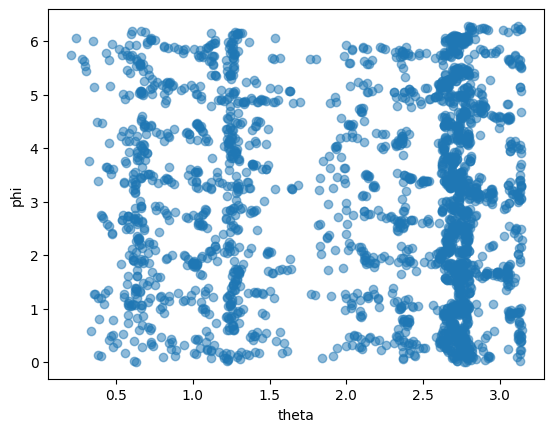

In [6]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

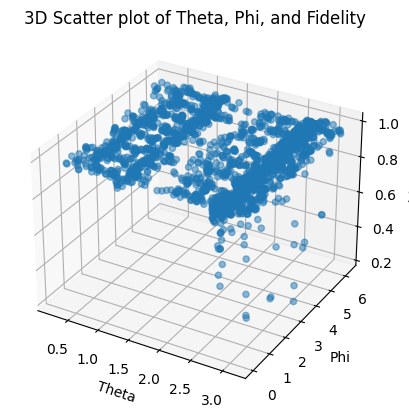

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
